# Comparing Player Tracking **With** and **Without** ViT (CLIP)

In this notebook we compare two strategies for following the same player across frames:

1. **Baseline – ByteTrack only**  
   We simply keep the same `track_id` that ByteTrack assigned in the anchor frame and check whether that `track_id` is present in the following frames.

2. **ViT/CLIP-based re-identification**  
   We use a Vision Transformer (CLIP ViT-B/32) to compute a visual embedding of the anchor player (appearance


In [35]:
import sys
sys.path.append(r"C:\Users\erick\Documents\HeatMapAV")


In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.video_utils import read_video
from tracker import Tracker
from appearance.clip_encoder import CLIPEncoder

%matplotlib inline



## 1. Load video and tracking data

We use the existing pipeline to:

- Read the input video
- Load the precomputed tracking data from a stub (`tracks_stub.pkl`), so we do not need to run YOLO + ByteTrack again inside this notebook.


In [37]:
VIDEO_PATH = r"C:\Users\erick\Documents\HeatMapAV\input_videos\test_2.mp4"
STUB_PATH = r"C:\Users\erick\Documents\HeatMapAV\stubs\tracks_stub.pkl"
MODEL_PATH = r"C:\Users\erick\Documents\HeatMapAV\models\best.pt"

# 1) Read video frames
frames = read_video(VIDEO_PATH)
print("Total frames in original video:", len(frames), "Frame shape:", frames[0].shape)

# 2) Load tracks using the stub
tracker = Tracker(MODEL_PATH)
tracks = tracker.get_object_tracks(
    frames,
    read_from_stub=True,
    stub_path=STUB_PATH
)

print("Total 'players' entries:", len(tracks["players"]))

# Optional: keep only the first N frames so tests run faster
MAX_FRAMES = 10  # you can change this to 50, 100, etc.
frames = frames[:MAX_FRAMES]
tracks["players"] = tracks["players"][:MAX_FRAMES]
tracks["referees"] = tracks["referees"][:MAX_FRAMES]
tracks["ball"] = tracks["ball"][:MAX_FRAMES]

print("Frames used in this notebook:", len(frames))


Total frames in original video: 750 Frame shape: (1080, 1920, 3)
Total 'players' entries: 750
Frames used in this notebook: 10


## 2. Select an anchor player

We now select:

- An **anchor frame** (for example, frame 0)
- A **track_id** in that frame that we want to follow

This player will be our "target player" for both the baseline method and the CLIP-based method.


In [57]:
anchor_frame_idx = 0  # frame where the player is clearly visible

players_in_first_frame = tracks["players"][anchor_frame_idx]
players_in_first_frame

anchor_track_id = list(players_in_first_frame.keys())[2]  # or set a specific id, e.g. 3
anchor_track_id

np.int64(3)

In [58]:
def crop_from_bbox(frame, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    h, w = frame.shape[:2]
    x1 = max(0, min(x1, w-1))
    x2 = max(0, min(x2, w-1))
    y1 = max(0, min(y1, h-1))
    y2 = max(0, min(y2, h-1))
    if x2 <= x1 or y2 <= y1:
        return None
    return frame[y1:y2, x1:x2]

def cosine_sim(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
    return float(np.dot(a, b) / denom)


## 3. Visualize the anchor player and compute its CLIP embedding

We now:

1. Extract the bounding box corresponding to the anchor player in the anchor frame
2. Crop the image
3. Display it
4. Compute its CLIP embedding (appearance descriptor)


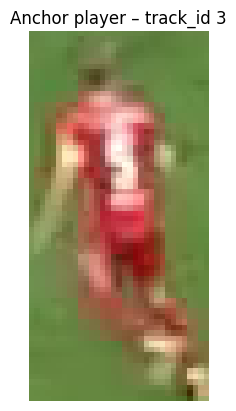

(768,)

In [59]:
# Initialize CLIP Vision Transformer
encoder = CLIPEncoder()

# Get anchor crop
anchor_frame = frames[anchor_frame_idx]
anchor_bbox = tracks["players"][anchor_frame_idx][anchor_track_id]["bbox"]
anchor_crop = crop_from_bbox(anchor_frame, anchor_bbox)

plt.imshow(cv2.cvtColor(anchor_crop, cv2.COLOR_BGR2RGB))
plt.title(f"Anchor player – track_id {anchor_track_id}")
plt.axis("off")
plt.show()

# Compute anchor embedding
anchor_emb = encoder.encode(anchor_crop)
anchor_emb.shape


## 4. Baseline strategy: ByteTrack only (no CLIP)

Baseline method:

- We assume the `track_id` of the anchor player remains the same in all frames.
- For each frame, we check whether the same `track_id` is present.
- If ByteTrack loses the player (no entry for that `track_id`), we mark the frame as `None`.

We will later compare this with the CLIP-based method.


In [60]:
baseline_boxes = []

for i in range(len(frames)):
    player_dict = tracks["players"][i]
    info = player_dict.get(anchor_track_id, None)
    if info is None:
        baseline_boxes.append(None)
    else:
        baseline_boxes.append(info["bbox"])

lost_baseline = sum(1 for b in baseline_boxes if b is None)
print("Frames where ByteTrack does NOT have the anchor player:", lost_baseline)
print("First 10 baseline boxes:", baseline_boxes[:10])


Frames where ByteTrack does NOT have the anchor player: 2
First 10 baseline boxes: [[519.9957275390625, 511.87188720703125, 552.6428833007812, 579.2325439453125], [515.8140258789062, 513.4028930664062, 553.4691162109375, 578.7374877929688], [511.2646179199219, 513.1492309570312, 550.9475708007812, 575.3423461914062], [507.3551330566406, 511.6181945800781, 548.1585083007812, 577.568115234375], [501.40576171875, 510.1410827636719, 543.037353515625, 575.8665161132812], [499.4037170410156, 509.3372497558594, 539.5037841796875, 576.1875610351562], [497.8303527832031, 513.8767700195312, 534.7621459960938, 575.1322631835938], [495.0921936035156, 516.9252319335938, 522.6304931640625, 576.6724853515625], None, None]


## 5. CLIP-based strategy: visual re-identification

CLIP method:

- For each frame, we consider **all detected players**.
- For each player, we crop the bounding box and compute a CLIP embedding.
- We compute the cosine similarity between this embedding and the anchor embedding.
- We select the player with the **highest similarity** as the "CLIP-selected" player in that frame.

This simulates a re-identification module based on a Vision Transformer.


In [61]:
clip_boxes = []
clip_track_ids = []
clip_sims = []  # similarity with anchor for the selected player

for i, frame in enumerate(frames):
    player_dict = tracks["players"][i]
    if not player_dict:
        clip_boxes.append(None)
        clip_track_ids.append(None)
        clip_sims.append(None)
        continue

    best_sim = -1.0
    best_bbox = None
    best_tid = None

    for tid, info in player_dict.items():
        bbox = info["bbox"]
        crop = crop_from_bbox(frame, bbox)
        if crop is None:
            continue

        emb = encoder.encode(crop)
        sim = cosine_sim(anchor_emb, emb)

        if sim > best_sim:
            best_sim = sim
            best_bbox = bbox
            best_tid = tid

    clip_boxes.append(best_bbox)
    clip_track_ids.append(best_tid)
    clip_sims.append(best_sim)

len(clip_boxes)


10

## 6. Quantitative comparison: ByteTrack vs CLIP

We now compare:

- How many frames lose the player when we rely only on ByteTrack (`track_id`).
- How many of those frames still get a plausible player when using CLIP.
- How often CLIP selects the same `track_id` as the baseline.


Frames where ByteTrack loses the player but CLIP still selects a player: 2
Frames where CLIP also selects the anchor track_id: 3


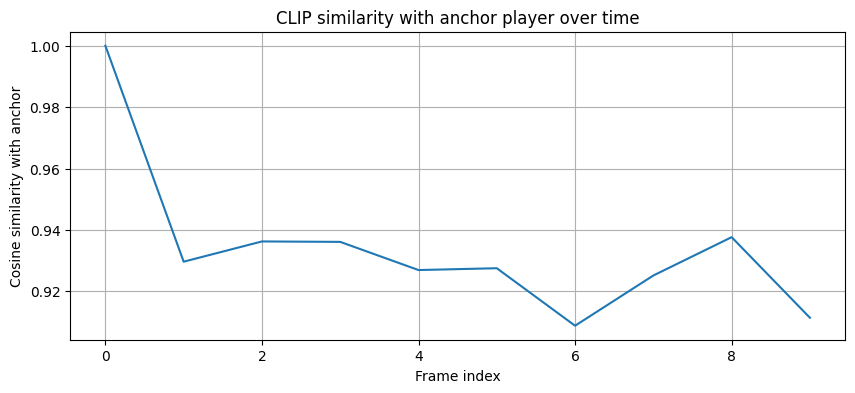

In [62]:
# A) frames where baseline is None but CLIP selects some player
recovered_by_clip = 0
for b_box, c_box in zip(baseline_boxes, clip_boxes):
    if b_box is None and c_box is not None:
        recovered_by_clip += 1

print("Frames where ByteTrack loses the player but CLIP still selects a player:", 
      recovered_by_clip)

# B) frames where CLIP selects the exact same track_id as the anchor
same_id_count = 0
for i, (baseline_box, clip_tid) in enumerate(zip(baseline_boxes, clip_track_ids)):
    if baseline_box is None:
        continue
    if clip_tid == anchor_track_id:
        same_id_count += 1

print("Frames where CLIP also selects the anchor track_id:", same_id_count)

# C) Plot similarity per frame
plt.figure(figsize=(10,4))
plt.plot([s if s is not None else 0 for s in clip_sims])
plt.xlabel("Frame index")
plt.ylabel("Cosine similarity with anchor")
plt.title("CLIP similarity with anchor player over time")
plt.grid(True)
plt.show()


## 7. Visual comparison on sample frames

Below we visualize a few sample frames and draw:

- **Blue box**: baseline (ByteTrack only, same `track_id` as the anchor)
- **Red box**: CLIP-selected player (highest similarity with the anchor embedding)

This helps illustrate how the Vision Transformer can recover or refine the identity of the target player.


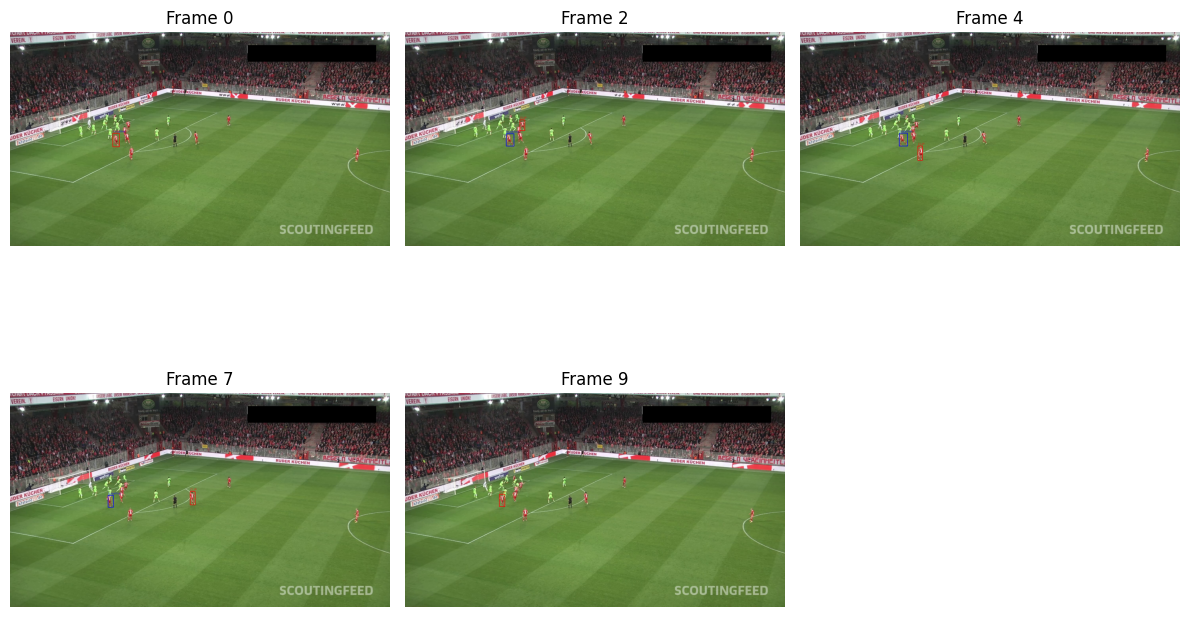

In [67]:
def draw_bbox(frame, bbox, color, label=None):
    if bbox is None:
        return frame
    x1, y1, x2, y2 = map(int, bbox)
    frame = frame.copy()
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
    if label is not None:
        cv2.putText(frame, label, (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return frame

sample_frames = [0, 2,4,7,9]  # choose any frame indices you like

plt.figure(figsize=(12,8))
for idx, fi in enumerate(sample_frames, 1):
    frame = frames[fi]
    f2 = draw_bbox(frame, baseline_boxes[fi], (255, 0, 0), "baseline")
    f2 = draw_bbox(f2, clip_boxes[fi], (0, 0, 255), "CLIP")

    plt.subplot(2, 3, idx)
    plt.imshow(cv2.cvtColor(f2, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {fi}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Limitations of Using a Single Static Pivot (Frame 0 Only)

Before implementing the improved tracking strategy, we tested a simple CLIP-based approach where:

- A **single anchor embedding** was taken from **frame 0**.
- In every new frame, CLIP compared this fixed embedding against **all detected players**, selecting the one with the highest similarity.

While this demonstrates the use of a Vision Transformer as an appearance encoder, it also exposes several major limitations that make the method unsuitable for stable long-term tracking.

---

## 1. Visual Appearance Changes Over Time

A player's visual appearance changes naturally as the match progresses due to:

- changes in pose and body orientation  
- occlusions by teammates or opponents  
- scaling differences (player gets closer or further from the camera)  
- motion blur  
- lighting and shadows  

Because the pivot embedding comes **only from frame 0**, it becomes increasingly outdated as the match continues.

**Result:**  
CLIP begins to match the anchor with players who only *loosely* resemble the initial appearance, especially when the true player becomes small or occluded.

---

## 2. No Temporal Continuity → Unrealistic Identity Jumps

With the static-pivot method, CLIP compares the anchor to all players in each frame **without considering**:

- where the player was in the previous frame  
- how fast the player can move  
- physical constraints on motion  

Thus, CLIP may suddenly select a player **far across the field** only because that player looks visually similar at that moment.

**Result:**  
The selected identity can “teleport” across the field — something physically impossible.

---

## 3. The Embedding Becomes Stale (“Frozen Identity”)

When the anchor embedding never updates, the system compares:

- a **static** representation (frame 0)  
with
- a **dynamic** player whose appearance changes constantly  

Over time, the similarity between the true player and the static pivot decreases, making other players appear more similar to the anchor than the actual target.

**Result:**  
Identity drift: CLIP gradually “locks onto” the wrong players.

---

## 4. Ignores Valuable Information From YOLO + ByteTrack

ByteTrack already provides:

- motion continuity  
- temporally stable identities (when possible)  
- spatial consistency  
- smooth tracking  

The static-pivot CLIP method discards all of this and relies entirely on visual similarity, which is brittle when:

- uniforms are similar  
- players cluster tightly  
- scale changes dramatically  
- the camera moves or zooms  

**Result:**  
CLIP becomes the *only* decision-maker, increasing the chance of confusion and tracking errors.

---

## 5. Higher Computational Cost Than Necessary

The static-pivot strategy computes CLIP embeddings for **all players in all frames**, even when ByteTrack already knows where the player is.

But most of the time, the tracker is correct — CLIP is only needed when the ID is lost or ambiguous.

**Result:**  
Unnecessary CLIP computations slow down execution without improving performance.

---

# Summary: Why the Static-Pivot CLIP Approach Fails

This method suffers from:

- ❌ Drift caused by appearance changes  
- ❌ Teleporting identity jumps (no motion continuity)  
- ❌ Outdated identity model  
- ❌ Ignoring existing tracker information  
- ❌ Excessive computation  

These problems make the approach unstable and unreliable for long video sequences.

---

# Motivation for a New Approach

To address these limitations, a new **rolling-pivot strategy** is proposed:

- Use YOLO + ByteTrack as the **primary tracker**  
- Use CLIP **only when ByteTrack loses the ID**  
- Maintain a **rolling anchor embedding** updated over time  
- Restrict CLIP comparisons to a **local spatial neighborhood**  
- Combine motion continuity with visual similarity  

This hybrid method produces a far more robust identity tracking system, essential for generating accurate single-player heatmaps.
